In [ ]:
__nbid__ = '0053'
__author__ = 'Eric Armengaud, Benjamin Weaver <benjamin.weaver@noirlab.edu>, Alice Jacques <alice.jacques@noirlab.edu>'
__version__ = '20250317' # yyyymmdd
__datasets__ = ['sdss_dr16', 'boss_dr16', 'desi_dr1']
__keywords__ = ['sparcl', 'spectroscopy', 'sdss spectra', 'desi spectra', 'tutorial', 'prospect', 'specutils']

# Obtain and plot spectra data using SPARCL, prospect, and specutils

*Credit*: [Eric Armengaud](https://github.com/armengau), Saclay - CEA, is the primary author of prospect. See also the [prospect contributors](https://github.com/desihub/prospect/graphs/contributors). [Benjamin Weaver](https://github.com/weaverba137) and [Alice Jacques](https://github.com/jacquesalice) contributed to the development of this notebook.

### Table of contents
* [Goals](#goals)
* [Disclaimer & attribution](#disclaimer)
* [Imports and setup](#imports)
* Find, retrieve, and plot spectra from:
    * [DESI](#desi)
    * [SDSS](#sdss)
    * [(e)BOSS](#boss)

<a class="anchor" id="goals"></a>
## Goals
*Project*: Obtain DESI DR1, SDSS DR16, and (e)BOSS DR16 spectra using the [NOIRLab SPARCL spectrum service](https://astrosparcl.datalab.noirlab.edu), convert data to [specutils objects](https://specutils.readthedocs.io/en/stable/) as needed, and use [prospect](https://desi-prospect.readthedocs.io/en/latest/) to display the data.

*Takeaway*: At no point in this notebook will any data files be opened.

*Takeaway*: prospect allows multiple, independent spectra visualizations to coexist within the same notebook.

This notebook is an adaptation of the [Prospect + specutils + SPARCL](https://github.com/desihub/prospect/blob/main/doc/nb/Prospect_spectrum_service.ipynb) notebook.

<a class="anchor" id="attribution"></a>
## Disclaimer & attribution

### Disclaimers

Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

### Acknowledgments

If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

For this notebook specifically, please acknowledge:

* prospect: [Eric Armengaud](https://github.com/armengau), Saclay - CEA, the primary author of prospect. See also the [prospect contributors](https://github.com/desihub/prospect/graphs/contributors).

<a class="anchor" id="imports"></a>
## Imports and setup

Note that we are not relying heavily on the DESI software stack (`DESI 23.1`), although some imports will be embedded within `prospect`.

In [1]:
from numba import NumbaDeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning, message=r'.*numba\.jit.*')
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.nddata import InverseVariance
from specutils import __version__ as specutils_version, Spectrum1D
from bokeh import __version__ as bokeh_version
from prospect import __version__ as prospect_version
from prospect.viewer import plotspectra
from prospect.specutils import Spectra
from redrock import __version__ as redrock_version
from redrock.templates import get_template_dir, load_templates
from sparcl import __version__ as sparcl_version
from sparcl.client import SparclClient
from dl import __version__ as dl_version, queryClient as qc, authClient as ac
print(f"astro-datalab=={dl_version}")
print(f"specutils=={specutils_version}")
print(f"bokeh=={bokeh_version}")
print(f"prospect=={prospect_version}")
print(f"redrock=={redrock_version}")
print(f"sparcl=={sparcl_version}")

astro-datalab==2.24.0
specutils==1.13.0
bokeh==2.4.3
prospect==1.3.3
redrock==0.20.4
sparcl==1.2.6


### Authentication

Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (*i.e.* you will need a registered user account).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [2]:
# from getpass import getpass
# token = ac.login(input("Enter user name: (+ENTER) "), getpass("Enter password: (+ENTER) "))
# ac.whoAmI()

### Start SPARCL Client

In [3]:
client = SparclClient()
client

announcement=Data set deprecation warning: SDSS/BOSS DR16 will be replaced with SDSS/BOSS DR17 starting on or after November 1, 2025


(sparclclient:1.2.6, api:12.0, https://astrosparcl.datalab.noirlab.edu/sparc, client_hash=9c2809d8cf5c0c90ba88e7fb207e61b4926a2ba7, verbose=False, connect_timeout=1.1, read_timeout=5400.0, announcement=True)

### Set up Data Lab database interface

All data should be visible in the 'default' profile

In [4]:
qc.get_profile()

'default'

<a class="anchor" id="desi"></a>
## DESI DR1

### Find DESI spectra

SPARCL provides access to DESI spectra that have been coadded by HEALPixel.  This corresponds to entries in the `desi_dr1.zpix` table at Astro Data Lab (see column information [here](https://datalab.noirlab.edu/query.php?name=desi_dr1.zpix)).

In [ ]:
q = """
SELECT z.targetid, z.chi2, z.z, z.zerr, z.zwarn, z.spectype, z.subtype,
       z.coadd_numexp, z.coadd_exptime, z.healpix, z.deltachi2
FROM desi_dr1.zpix AS z
WHERE z.zcat_primary
    AND z.survey = 'main'
    AND z.program = 'dark'
    AND z.spectype = 'GALAXY'
    AND z.z BETWEEN 0.5 AND 0.9
    AND z.zwarn = 0
ORDER BY z.targetid
LIMIT 50
"""
desi_ids = qc.query(sql=q, fmt='table')
desi_ids

**QA**: Do we really have 50 unique spectra?

In [ ]:
assert (np.unique(desi_ids['targetid']) == desi_ids['targetid']).all()

### Retrieve DESI spectra

With the set of `targetid` obtained above, we can directly retrieve DESI spectra.

In [ ]:
include = client.get_all_fields(dataset_list=['DESI-DR1'])
desi_spectra = client.retrieve_by_specid(specid_list=desi_ids['targetid'].value.tolist(),
                                         include=include,
                                         dataset_list=['DESI-DR1'])
desi_spectra.info

**QA**: Did we really find all of the expected spectra?

Side effect: this also sorts the returned records to match the order of the inputs.

In [ ]:
desi_records = sorted(desi_spectra.records, key=lambda x: x.targetid)
assert (np.array([r.targetid for r in desi_records]) == desi_ids['targetid']).all()
assert all([r.survey == 'main' for r in desi_records])
assert all([r.program == 'dark' for r in desi_records])

**QA**: Do all spectra records have the same wavelength solution?

In [ ]:
assert all([(r.wavelength == desi_records[0].wavelength).all() for r in desi_records])

**QA**: Are any of the spectra fully masked?

In [ ]:
desi_fully_masked = np.zeros((len(desi_records), ), dtype=bool)

for k in range(len(desi_records)):
    assert np.isfinite(desi_records[k].flux).all()
    assert np.isfinite(desi_records[k].ivar).all()
    if (desi_records[k].mask > 0).all():
        print(f"WARNING: Spectrum record {k:d} is fully masked!")
        desi_fully_masked[k] = True

#### View the contents of the first retrieved record

In [ ]:
desi_records[0]

### Organize metadata

Prospect needs several inputs:

1. An object containing spectra.  In this case we'll use [`prospect.specutils.Spectra`](https://desi-prospect.readthedocs.io/en/latest/api.html#prospect.specutils.Spectra), which inherits from [`SpectrumList`](https://specutils.readthedocs.io/en/stable/api/specutils.SpectrumList.html#specutils.SpectrumList), and is really just a [`Spectrum1D`](https://specutils.readthedocs.io/en/stable/api/specutils.Spectrum1D.html#specutils.Spectrum1D) object underneath.
   * The object contains the usual flux, wavelength, uncertainty.
   * In addtion a "fibermap" table is needed. This should be an Astropy `Table` with the expected columns.
2. A redshift catalog. This should be an Astropy `Table` with the expected columns.
3. A model spectrum.  The model is actually provided by SPARCL, but we need to input it separately.

#### Spectrum object

First we assemble the components of the spectrum object

In [ ]:
flux = np.zeros((len(desi_records), desi_records[0].flux.shape[0]),
                dtype=desi_records[0].flux.dtype)
uncertainty = np.zeros((len(desi_records), desi_records[0].ivar.shape[0]),
                       dtype=desi_records[0].ivar.dtype)
mask = np.zeros((len(desi_records), desi_records[0].mask.shape[0]),
                dtype=desi_records[0].mask.dtype)

meta = {'sparcl_id': list(), 'data_release': list()}
sparcl_id = list()
data_release = list()

for k in range(len(desi_records)):
    flux[k, :] = desi_records[k].flux
    uncertainty[k, :] = desi_records[k].ivar
    mask[k, :] = desi_records[k].mask
    meta['sparcl_id'].append(desi_records[k].sparcl_id)
    meta['data_release'].append(desi_records[k].data_release)

And the "fibermap" table. We'll start with photometric quantities.

In [ ]:
columns = ('targetid', 'ra', 'dec', 'ref_epoch', 'pmra', 'pmdec', 'ebv',
           'flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2')
q = """
SELECT {0}
FROM desi_dr1.photometry
WHERE targetid IN ({1})
ORDER BY targetid
""".format(', '.join(columns), ', '.join([str(t) for t in desi_ids['targetid'].value.tolist()]))

fibermap = qc.query(sql=q, fmt='table')

In [ ]:
for col in fibermap.colnames:
    if col == 'ra' or col == 'dec':
        fibermap.rename_column(col, 'TARGET_' + col.upper())
    else:
        fibermap.rename_column(col, col.upper())

**QA**: Did we find photometry for every `targetid`?

In [ ]:
assert (fibermap['TARGETID'] == desi_ids['targetid']).all()

Next we add targeting bitmasks.

In [ ]:
columns = ('targetid', 'desi_target', 'bgs_target', 'mws_target', 'scnd_target')
q = """
SELECT DISTINCT {0}
FROM desi_dr1.target
WHERE targetid IN ({1})
ORDER BY targetid
""".format(', '.join(columns), ', '.join([str(t) for t in fibermap['TARGETID'].value.tolist()]))

targeting = qc.query(sql=q, fmt='table')

In [ ]:
for col in targeting.colnames:
    targeting.rename_column(col, col.upper())

**QA**: Did we find targeting for every `targetid`?

In [ ]:
assert (targeting['TARGETID'] == fibermap['TARGETID']).all()

**QA**: Does the order of fibermap match the SPARCL records?

In [ ]:
assert (np.array([r.targetid for r in desi_records]) == fibermap['TARGETID']).all()

Add columns into `fibermap`.

In [ ]:
for col in ('DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'SCND_TARGET'):
    fibermap.add_column(targeting[col])
fibermap

Finally assemble the object.

In [ ]:
desi_prospect = Spectra(bands=['coadd'],
                        wave={'coadd': desi_records[0].wavelength},
                        flux={'coadd': flux[~desi_fully_masked, :]},
                        ivar={'coadd': uncertainty[~desi_fully_masked, :]},
                        mask={'coadd': mask[~desi_fully_masked, :]},
                        fibermap=fibermap[~desi_fully_masked],
                        meta={'coadd': meta})

#### Redshift catalog

We can re-use the initial query above; it was deliberately constructed.

In [ ]:
desi_zcatalog = desi_ids.copy()
for col in desi_zcatalog.colnames:
    if col == 'healpix':
        desi_zcatalog.rename_column(col, 'HPXPIXEL')
    else:
        desi_zcatalog.rename_column(col, col.upper())
desi_zcatalog

#### Model spectra

Prospect expects a model in the form of a tuple containing wavelength and flux. Since SPARCL provides the model, this is easy.  There are other ways to specify the model, but these require more access to the DESI software stack *and* data *files*.

In [ ]:
model_flux = np.zeros((len(desi_records), desi_records[0].model.shape[0]),
                      dtype=desi_records[0].model.dtype)

for k in range(len(desi_records)):
        model_flux[k, :] = desi_records[k].model

desi_model = (desi_records[0].wavelength, model_flux[~desi_fully_masked, :])

### Start prospect

With everything assembled, the interface to prospect is just a single call.  Note that we're setting `with_vi_widgets=True` in order to fully describe the prospect display. Other visualization examples below will have `with_vi_widgets=False`.

Further details about the prospect display:

* The large window displays a spectrum with best fit model overlaid.
* Scanning the mouse over that plot shows a full-resolution zoom of that portion of the spectrum to the right, which is particularly useful for scanning narrow emission lines.
* Try the various tools at the top for panning, zooming, selecting. When the wheel zoom tool is selected (default), using the scroll wheel will zoom in and out. Point the mouse over the x or y axis before scrolling to zoom on just that axis.
* Click on one of the legend entries to the lower right to turn that item on or off.
* The example below includes visual inspection (VI) tools, in a shaded box to the lower left. This allows individuals to rate spectra on questions such as "is the redshift accurate?", or "is the object really a galaxy as opposed to a star?". Guidelines on using the VI tools are just below the tools themselves.
* Immediately above the VI tools are arrows and a slider for displaying other spectra.
* To the right of the VI tools are metadata about the spectrum, interspersed with tools for smoothing the spectrum, manually changing the redshift of the best-fit model, and toggling the display of emission and absorption line markers.


In [ ]:
plotspectra(desi_prospect,
            zcatalog=desi_zcatalog[~desi_fully_masked],
            redrock_cat=None,
            notebook=True,
            with_thumb_tab=False,
            with_vi_widgets=True,
            with_coaddcam=False,
            mask_type='DESI_TARGET',
            model_from_zcat=False,
            model=desi_model)

### Model spectra in DESI DR1

We can reconstruct the official DESI models using software from [redrock](https://github.com/desihub/redrock). See https://github.com/desihub/tutorials/blob/main/02_digging_deeper/RedrockOutputs.ipynb for a in-depth tutorial.

Goal: compare a SPARCL model spectrum to one computed from the files.

#### Load DR1 templates

In [5]:
specprod = 'iron'
template_dir = get_template_dir()
templates = load_templates(f'{template_dir}/templates-{specprod}.txt', asdict=True)

DEBUG: Reading templates from /data0/sw/desi/code/redrock-templates/0.9.1/templates-iron.txt
Reading templates from ['/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-GALAXY-None-v2.6.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-QSO-LOZ-v1.0.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-QSO-HIZ-v1.0.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-STAR-A-v0.1.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-STAR-B-v0.1.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-STAR-CV-v0.1.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-STAR-F-v0.1.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-STAR-G-v0.1.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-STAR-K-v0.1.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-STAR-M-v0.1.fits', '/data0/sw/desi/code/redrock-templates/0.9.1/rrtemplate-STAR-WD-v0.1.fits']
INFO: rrtemplate-GALAXY-None-v2.6.fits GALAXY  PC

#### Find a set of QSOs

There are two different sets of QSO templates, `LOZ` and `HIZ`, corresponding to different subtypes for `QSO` spectypes. This query will return a set of spectra with both `LOZ` and `HIZ` subtypes.

In [ ]:
q = """
SELECT z.targetid, z.chi2, z.z, z.zerr, z.zwarn, z.spectype, z.subtype,
       z.coadd_numexp, z.coadd_exptime, z.healpix, z.deltachi2,
       z.ncoeff, z.coeff_0, z.coeff_1, z.coeff_2, z.coeff_3, z.coeff_4,
       z.coeff_5, z.coeff_6, z.coeff_7, z.coeff_8, z.coeff_9
FROM desi_dr1.zpix AS z
WHERE z.zcat_primary
    AND z.survey = 'main'
    AND z.program = 'dark'
    AND z.spectype = 'QSO'
    AND z.z BETWEEN 1.0 AND 4.0
    AND z.zwarn = 0
ORDER BY z.targetid
LIMIT 50
"""


In [21]:
q = """
SELECT z.targetid, z.chi2, z.z, z.zerr, z.zwarn, z.spectype, z.subtype,
       z.coadd_numexp, z.coadd_exptime, z.healpix, z.deltachi2,
       z.ncoeff, z.coeff_0, z.coeff_1, z.coeff_2, z.coeff_3, z.coeff_4,
       z.coeff_5, z.coeff_6, z.coeff_7, z.coeff_8, z.coeff_9
FROM desi_dr1.zpix AS z
WHERE z.zcat_primary
    AND z.survey = 'main'
    AND z.program = 'dark'
    AND z.spectype = 'GALAXY'
    AND z.z BETWEEN 0.5 AND 0.9
    AND z.zwarn = 0
ORDER BY z.targetid
LIMIT 50
"""


In [22]:
desi_qso_ids = qc.query(sql=q, fmt='table')
desi_qso_ids

targetid,chi2,z,zerr,zwarn,spectype,subtype,coadd_numexp,coadd_exptime,healpix,deltachi2,ncoeff,coeff_0,coeff_1,coeff_2,coeff_3,coeff_4,coeff_5,coeff_6,coeff_7,coeff_8,coeff_9
int64,float64,float64,float64,int64,str6,int64,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2204871004520448,7502.786605030298,0.8806668589719826,9.349553024613176e-05,0,GALAXY,--,1,1046.75,25978,9.219138950109482,10,1.098698056156196,44.25722355708083,-1.151029649951285,10.26593431013441,0.0,0.0,0.0,0.0,0.0,0.0
2209099441766401,8006.957153789699,0.5376416668826327,8.224065899198639e-05,0,GALAXY,--,1,1260.4886,25557,23.28271762281656,10,31.26894258497333,-12.98628961582737,1.065099943244334,13.6369149794925,0.3097505221826301,-3.150165613576458,-3.882342433750344,4.20893748521098,-0.3677328764207575,-2.826179295683271
2253218688008192,8434.394513607025,0.7807731132992886,9.001776300184597e-05,0,GALAXY,--,1,949.2782,27650,80.38463451713324,10,0.3563463045356275,17.3847327380159,2.487453572488868,-5.077508457685314,0.0,0.0,0.0,0.0,0.0,0.0
2253239848271873,8068.217628836632,0.8138682719950381,9.584803411923739e-05,0,GALAXY,--,2,2201.3787,19462,11.19063480198383,10,71.16006797130082,-45.63776434323334,-260.4378989671721,-118.3543011283282,221.6836747964141,-85.05629617990108,-11.80712772188747,-97.09586407019344,18.00502833126158,2.314039001214395
2253330273271809,8256.472001791,0.6026842080317678,2.811214761433289e-05,0,GALAXY,--,1,1320.7625,19505,54.08813303161878,10,68.58581704059822,-63.77227140754194,-325.7134617382558,-140.6585828063363,306.9917244963104,-131.5865339958247,-13.572441853062,-133.4388910040853,35.00849525129802,-3.348652788419436
2253938946473984,7914.019844397902,0.6929688143203399,6.916722607803487e-05,0,GALAXY,--,1,824.6894,9161,11.24665383994579,10,-448.7807938231027,612.9185191405513,-341.9824708997333,291.8559216368241,0.9094677855861807,-33.7576279642128,-157.299875202538,-14.61077830869137,25.59366810619733,-16.50880919980512
2315501380304901,8566.17580628395,0.7495491546701545,1.825370572872369e-05,0,GALAXY,--,1,1023.1347,9160,157.1781300567091,10,222.506177810897,789.5975534219858,-152.5421898328919,142.7051708870783,-15.41658467516,3.288397981811491,-111.192972711384,3.231458033588942,3.031770032869014,-14.41236097827043
2323576464080897,10608.37604570389,0.6669901455530606,3.139990965279613e-05,0,GALAXY,--,2,2315.1829,31319,28.90390665084124,10,-124.4761678774265,136.8936726382584,1111.393345396289,494.0609901746434,-1035.541669235163,251.8555054542483,23.05744881603701,217.5278847034933,-43.86324913211317,-9.621694553682786
2349509577277441,8195.99036064744,0.6498143137995088,5.352659428856206e-05,0,GALAXY,--,2,2919.674,36254,30.97397623211145,10,110.0298695731969,-100.94942830484,49.77048849703118,-41.79972320259744,4.696818039787892,-8.758914860673709,15.52664233071824,-4.69078469226383,2.632566609965119,5.852677189363837


#### Convert the coefficients into an array

In [23]:
max_coeff = desi_qso_ids['ncoeff'].max()
coeff = np.zeros((len(desi_qso_ids), max_coeff), dtype=desi_qso_ids['coeff_0'].dtype)
for k in range(max_coeff):
    coeff[:, k] = desi_qso_ids[f'coeff_{k:d}'].data
# coeff

#### Retrieve the spectra and models from SPARCL

In [24]:
include = client.get_all_fields(dataset_list=['DESI-DR1'])
desi_qso_spectra = client.retrieve_by_specid(specid_list=desi_qso_ids['targetid'].value.tolist(),
                                             include=include,
                                             dataset_list=['DESI-DR1'])
desi_qso_spectra.info

{'status': {'success': True,
  'info': ["Successfully found 50 records in dr_list=['DESI-DR1']"],
  'warnings': []}}

Verify that we retrieved all the expected spectra, and sort the results to match the order of the inputs.

In [25]:
desi_qso_records = sorted(desi_qso_spectra.records, key=lambda x: x.targetid)
assert (np.array([r.targetid for r in desi_qso_records]) == desi_qso_ids['targetid']).all()

In [26]:
qso_flux = np.zeros((len(desi_qso_records), desi_qso_records[0].flux.shape[0]),
                    dtype=desi_qso_records[0].flux.dtype)
qso_model_flux = np.zeros((len(desi_qso_records), desi_qso_records[0].flux.shape[0]),
                          dtype=desi_qso_records[0].model.dtype)
qso_wavelength = desi_qso_records[0].wavelength
for k in range(len(desi_qso_records)):
    qso_flux[k, :] = desi_qso_records[k].flux
    qso_model_flux[k, :] = desi_qso_records[k].model        

#### Combine coefficients and templates to get the redrock models

In [28]:
# assert (desi_qso_ids['spectype'] == 'QSO').all()
# assert ((desi_qso_ids['subtype'] == 'HIZ') | (desi_qso_ids['subtype'] == 'LOZ')).all()
assert (desi_qso_ids['spectype'] == 'GALAXY').all()
# assert (desi_qso_ids['subtype'] == '').all()
qso_loz = templates[('QSO', 'LOZ')]
qso_hiz = templates[('QSO', 'HIZ')]
galaxy = templates[('GALAXY', '')]
tmpl_model_flux = np.zeros((len(desi_qso_ids), len(qso_wavelength)), dtype=qso_model_flux.dtype)
for i, row in enumerate(desi_qso_ids):
    # print(row)
    # print(coeff[i, :])
    if row['subtype'] == 'LOZ':
        tmpl_model_flux[i, :] = qso_loz.eval(coeff[i, :], qso_wavelength, row['z'])
    elif row['subtype'] == 'HIZ':
        tmpl_model_flux[i, :] = qso_hiz.eval(coeff[i, :], qso_wavelength, row['z'])
    else:
        tmpl_model_flux[i, :] = galaxy.eval(coeff[i, :], qso_wavelength, row['z'])

#### Comparison plot

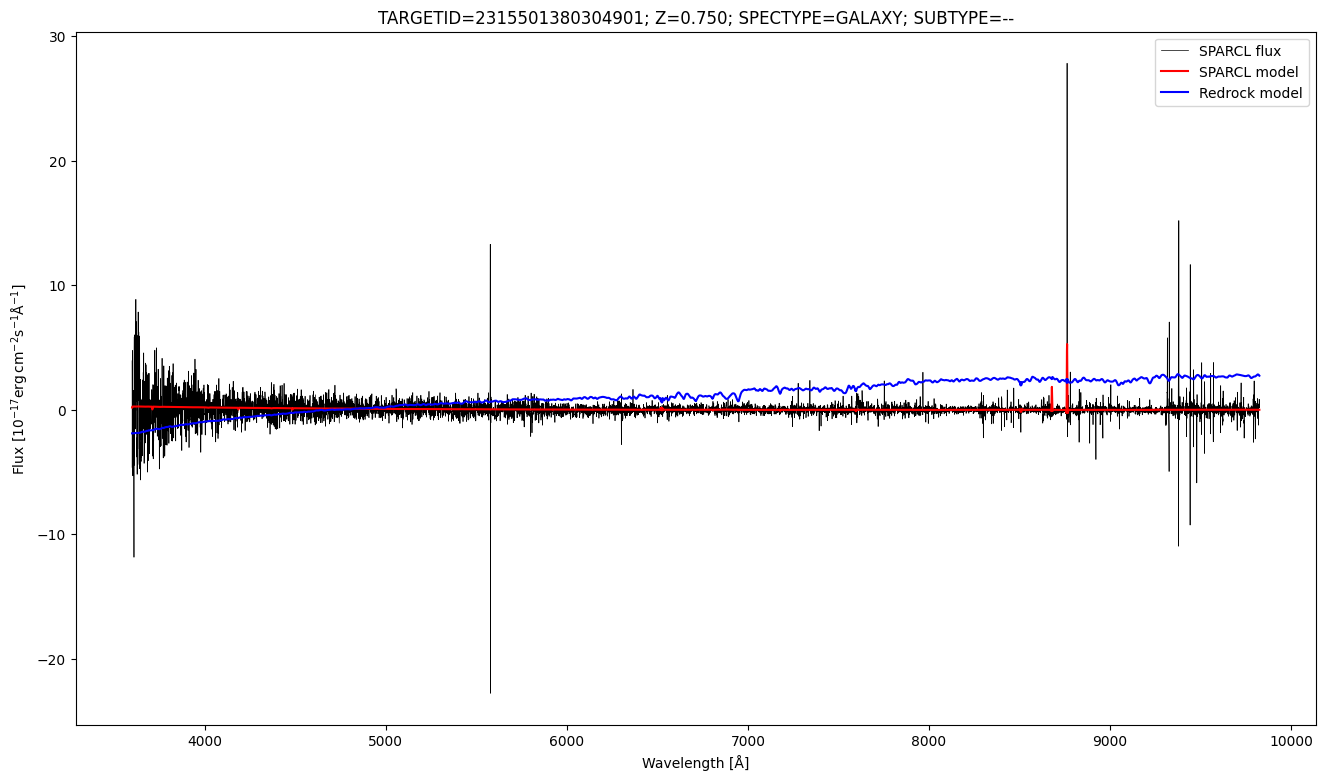

In [39]:
fig = plt.figure(figsize=(16, 9), dpi=100)
ax = fig.add_subplot(111)
spectrum_index = 6  # Step through spectra here.
pl0 = ax.plot(qso_wavelength, qso_flux[spectrum_index, :], 'k-', lw=0.5, label='SPARCL flux')
pl1 = ax.plot(qso_wavelength, qso_model_flux[spectrum_index, :], 'r-', label='SPARCL model')
pl2 = ax.plot(qso_wavelength, tmpl_model_flux[spectrum_index, :], 'b-', label='Redrock model')
txt = ax.set_xlabel('Wavelength [Å]')
txt = ax.set_ylabel(r'Flux [$10^{-17} \mathrm{erg} \, \mathrm{cm}^{-2} \mathrm{s}^{-1} \mathrm{\AA}^{-1}$]')
txt = ax.set_title(f"TARGETID={desi_qso_ids[spectrum_index]['targetid']:d}; Z={desi_qso_ids[spectrum_index]['z']:.3f}; SPECTYPE={desi_qso_ids[spectrum_index]['spectype']}; SUBTYPE={desi_qso_ids[spectrum_index]['subtype']}")
l = ax.legend()

<a class="anchor" id="sdss"></a>
## SDSS

### Find SDSS spectra

In [ ]:
q = """
SELECT z.specobjid, z.bestobjid, z.z, z.zerr, z.zwarning, z.class, z.subclass,
       z.rchi2diff, z.primtarget, z.sectarget
FROM sdss_dr16.specobj AS z
WHERE z.bestobjid > 0
    AND z.run2d = '26'
    AND z.plate = 2955
    AND z.mjd = 54562
    AND z.class = 'GALAXY'
    AND z.zwarning = 0
ORDER BY z.specobjid
LIMIT 50
"""
sdss_ids = qc.query(sql=q, fmt='table')
sdss_ids

**QA**: Do we really have 50 unique spectra?

In [ ]:
assert (np.unique(sdss_ids['specobjid']) == sdss_ids['specobjid']).all()

### Retrieve SDSS spectra

With the set of `specobjid` obtained above, we can directly retrieve SDSS spectra.

In [ ]:
include = client.get_all_fields(dataset_list=['SDSS-DR16'])
sdss_spectra = client.retrieve_by_specid(specid_list=sdss_ids['specobjid'].value.tolist(),
                                         include=include,
                                         dataset_list=['SDSS-DR16'])
sdss_spectra.info

**QA**: Did we really find all of the expected spectra? Note that we have to assume `specid == specobjid`.

Side effect: this also sorts the returned records to match the order of the inputs.

In [ ]:
sdss_records = sorted(sdss_spectra.records, key=lambda x: x.specid)
assert (np.array([r.specid for r in sdss_records]) == sdss_ids['specobjid']).all()
assert all([r.plate == 2955 for r in sdss_records])
assert all([r.mjd == 54562 for r in sdss_records])

**QA**: Do all spectra records have the same wavelength solution?

In [ ]:
assert all([(r.wavelength == sdss_records[0].wavelength).all() for r in sdss_records])

**QA**: Are any of the spectra fully masked?

In [ ]:
sdss_fully_masked = np.zeros((len(sdss_records), ), dtype=bool)

for k in range(len(sdss_records)):
    assert np.isfinite(sdss_records[k].flux).all()
    assert np.isfinite(sdss_records[k].ivar).all()
    if (sdss_records[k].mask > 0).all():
        print(f"WARNING: Spectrum record {k:d} is fully masked!")
        sdss_fully_masked[k] = True

**Note** that one of the spectra has a non-zero mask for every pixel. This will cause problems with some versions of Prospect, so for the demonstration below, we will not attempt to plot that spectrum. Future versions of Prospect will handle this more gracefully.

#### View the contents of the first retrieved record

In [ ]:
sdss_records[0]

### Organize metadata

Prospect needs several inputs:

1. An object containing spectra.  In this case we'll use a [`Spectrum1D`](https://specutils.readthedocs.io/en/stable/api/specutils.Spectrum1D.html#specutils.Spectrum1D) object.
   * The object contains the usual flux, wavelength, uncertainty.
   * In addtion a "plugmap" table is needed. This should be an Astropy `Table` with the expected columns.
2. A redshift catalog. This should be an Astropy `Table` with the expected columns.
3. A model spectrum.  The model is actually provided by SPARCL, but we need to input it separately.

#### Spectrum object

First we assemble the components of the spectrum object

In [ ]:
flux = np.zeros((len(sdss_records), sdss_records[0].flux.shape[0]),
                dtype=sdss_records[0].flux.dtype)
uncertainty = np.zeros((len(sdss_records), sdss_records[0].ivar.shape[0]),
                       dtype=sdss_records[0].ivar.dtype)
mask = np.zeros((len(sdss_records), sdss_records[0].mask.shape[0]),
                dtype=sdss_records[0].mask.dtype)

meta = {'sparcl_id': list(), 'data_release': list()}
sparcl_id = list()
data_release = list()

for k in range(len(sdss_records)):
    flux[k, :] = sdss_records[k].flux
    uncertainty[k, :] = sdss_records[k].ivar
    mask[k, :] = sdss_records[k].mask
    meta['sparcl_id'].append(sdss_records[k].sparcl_id)
    meta['data_release'].append(sdss_records[k].data_release)

And the "plugmap" table. We'll start with photometric quantities.

In [ ]:
columns = ('z.specobjid', 'p.objid', 'p.ra', 'p.dec', 'p.u', 'p.g', 'p.r', 'p.i', 'p.z')
q = """
SELECT {0}
FROM sdss_dr16.specobj AS z
JOIN sdss_dr16.photoplate AS p
ON z.bestobjid = p.objid
WHERE p.objid IN ({1})
ORDER BY z.specobjid
""".format(', '.join(columns), ', '.join([str(t) for t in sdss_ids['bestobjid'].value.tolist()]))

plugmap = qc.query(sql=q, fmt='table')

In [ ]:
for col in plugmap.colnames:
    plugmap.rename_column(col, col.upper())
mag = np.zeros((len(plugmap), 5), dtype=plugmap['G'].value.dtype)
for k, band in enumerate('UGRIZ'):
    mag[:, k] = plugmap[band].value
plugmap.add_column(mag, name='MAG')
plugmap.add_column(sdss_ids['primtarget'], name='PRIMTARGET')
plugmap.add_column(sdss_ids['sectarget'], name='SECTARGET')
meta['plugmap'] = plugmap[~sdss_fully_masked]

**QA**: Did we find photometry for every `bestobjid`?

In [ ]:
assert (plugmap['OBJID'] == sdss_ids['bestobjid']).all()

Finally assemble the object.

In [ ]:
sdss_prospect = Spectrum1D(flux=flux[~sdss_fully_masked, :] * u.Unit('1e-17 erg / (Angstrom cm2 s)'),
                           spectral_axis=sdss_records[0].wavelength * u.Unit('Angstrom'),
                           uncertainty=InverseVariance(uncertainty[~sdss_fully_masked, :]),
                           mask=mask[~sdss_fully_masked, :] != 0,
                           meta=meta)

#### Redshift catalog

We can re-use the initial query above; it was deliberately constructed.

In [ ]:
sdss_zcatalog = sdss_ids.copy()
for col in sdss_zcatalog.colnames:
    if col == 'zerr':
        sdss_zcatalog.rename_column(col, 'Z_ERR')
    else:
        sdss_zcatalog.rename_column(col, col.upper())
sdss_zcatalog

#### Model spectra

Prospect expects a model in the form of a tuple containing wavelength and flux. Since SPARCL provides the model, this is easy.  There are other ways to specify the model, but these require more access to the SDSS *files*.

In [ ]:
model_flux = np.zeros((len(sdss_records), sdss_records[0].model.shape[0]),
                      dtype=sdss_records[0].model.dtype)

for k in range(len(sdss_records)):
        model_flux[k, :] = sdss_records[k].model

sdss_model = (sdss_records[0].wavelength, model_flux[~sdss_fully_masked, :])

### Start prospect

With everything assembled, the interface to prospect is just a single call.

In [ ]:
plotspectra(sdss_prospect,
            zcatalog=sdss_zcatalog[~sdss_fully_masked],
            redrock_cat=None,
            notebook=True,
            with_thumb_tab=False,
            with_vi_widgets=False,
            with_coaddcam=False,
            mask_type='PRIMTARGET',
            model_from_zcat=False,
            model=sdss_model)

<a class="anchor" id="boss"></a>
## (e)BOSS

### Find (e)BOSS spectra

In [ ]:
q = """
SELECT z.specobjid, z.bestobjid, z.z, z.zerr, z.zwarning, z.class, z.subclass,
       z.rchi2diff, z.boss_target1, z.eboss_target0, z.eboss_target1,
       z.eboss_target2
FROM sdss_dr16.specobj AS z
WHERE z.bestobjid > 0
    AND z.run2d = 'v5_13_0'
    AND z.plate = 9599
    AND z.mjd = 58131
    AND z.class = 'GALAXY'
    AND z.zwarning = 0
ORDER BY z.specobjid
LIMIT 50
"""
boss_ids = qc.query(sql=q, fmt='table')
boss_ids

**QA**: Do we really have 50 unique spectra?

In [ ]:
assert (np.unique(boss_ids['specobjid']) == boss_ids['specobjid']).all()

### Retrieve (e)BOSS spectra

With the set of `specobjid` obtained above, we can directly retrieve (e)BOSS spectra.

In [ ]:
include = client.get_all_fields(dataset_list=['BOSS-DR16'])
boss_spectra = client.retrieve_by_specid(specid_list=boss_ids['specobjid'].value.tolist(),
                                         include=include,
                                         dataset_list=['BOSS-DR16'])
boss_spectra.info

**QA**: Did we really find all of the expected spectra?

Side effect: this also sorts the returned records to match the order of the inputs.

In [ ]:
boss_records = sorted(boss_spectra.records, key=lambda x: x.specid)
assert (np.array([r.specid for r in boss_records]) == boss_ids['specobjid']).all()
assert all([r.plate == 9599 for r in boss_records])
assert all([r.mjd == 58131 for r in boss_records])

**QA**: Do all spectra records have the same wavelength solution?

In [ ]:
assert all([(r.wavelength == boss_records[0].wavelength).all() for r in boss_records])

**QA**: Are any of the spectra fully masked?

In [ ]:
boss_fully_masked = np.zeros((len(boss_records), ), dtype=bool)

for k in range(len(boss_records)):
    assert np.isfinite(boss_records[k].flux).all()
    assert np.isfinite(boss_records[k].ivar).all()
    if (boss_records[k].mask > 0).all():
        print(f"WARNING: Spectrum record {k:d} is fully masked!")
        boss_fully_masked[k] = True

#### View the contents of the first retrieved record

In [ ]:
boss_records[0]

### Organize metadata

Prospect needs several inputs:

1. An object containing spectra.  In this case we'll use a [`Spectrum1D`](https://specutils.readthedocs.io/en/stable/api/specutils.Spectrum1D.html#specutils.Spectrum1D) object.
   * The object contains the usual flux, wavelength, uncertainty.
   * In addtion a "plugmap" table is needed. This should be an Astropy `Table` with the expected columns.
2. A redshift catalog. This should be an Astropy `Table` with the expected columns.
3. A model spectrum.  The model is actually provided by SPARCL, but we need to input it separately.

#### Spectrum object

First we assemble the components of the spectrum object

In [ ]:
flux = np.zeros((len(boss_records), boss_records[0].flux.shape[0]),
                dtype=boss_records[0].flux.dtype)
uncertainty = np.zeros((len(boss_records), boss_records[0].ivar.shape[0]),
                       dtype=boss_records[0].ivar.dtype)
mask = np.zeros((len(boss_records), boss_records[0].mask.shape[0]),
                dtype=boss_records[0].mask.dtype)

meta = {'sparcl_id': list(), 'data_release': list()}
sparcl_id = list()
data_release = list()

for k in range(len(boss_records)):
    flux[k, :] = boss_records[k].flux
    uncertainty[k, :] = boss_records[k].ivar
    mask[k, :] = boss_records[k].mask
    meta['sparcl_id'].append(boss_records[k].sparcl_id)
    meta['data_release'].append(boss_records[k].data_release)

And the "plugmap" table. We'll start with photometric quantities.

In [ ]:
columns = ('z.specobjid', 'p.objid', 'p.ra', 'p.dec', 'p.u', 'p.g', 'p.r', 'p.i', 'p.z')
q = """
SELECT {0}
FROM sdss_dr16.specobj AS z
JOIN sdss_dr16.photoplate AS p
ON z.bestobjid = p.objid
WHERE p.objid IN ({1})
ORDER BY z.specobjid
""".format(', '.join(columns), ', '.join([str(t) for t in boss_ids['bestobjid'].value.tolist()]))

plugmap = qc.query(sql=q, fmt='table')

In [ ]:
for col in plugmap.colnames:
    plugmap.rename_column(col, col.upper())
mag = np.zeros((len(plugmap), 5), dtype=plugmap['G'].value.dtype)
for k, band in enumerate('UGRIZ'):
    mag[:, k] = plugmap[band].value
plugmap.add_column(mag, name='MAG')
plugmap.add_column(boss_ids['boss_target1'], name='BOSS_TARGET1')
plugmap.add_column(boss_ids['eboss_target0'], name='EBOSS_TARGET0')
plugmap.add_column(boss_ids['eboss_target1'], name='EBOSS_TARGET1')
plugmap.add_column(boss_ids['eboss_target2'], name='EBOSS_TARGET2')
meta['plugmap'] = plugmap[~boss_fully_masked]

**QA**: Did we find photometry for every `bestobjid`?

In [ ]:
assert (plugmap['OBJID'] == boss_ids['bestobjid']).all()

Finally assemble the object.

In [ ]:
boss_prospect = Spectrum1D(flux=flux[~boss_fully_masked, :] * u.Unit('1e-17 erg / (Angstrom cm2 s)'),
                           spectral_axis=boss_records[0].wavelength * u.Unit('Angstrom'),
                           uncertainty=InverseVariance(uncertainty[~boss_fully_masked, :]),
                           mask=mask[~boss_fully_masked, :] != 0,
                           meta=meta)

#### Redshift catalog

We can re-use the initial query above; it was deliberately constructed.

In [ ]:
boss_zcatalog = boss_ids.copy()
for col in boss_zcatalog.colnames:
    if col == 'zerr':
        boss_zcatalog.rename_column(col, 'Z_ERR')
    else:
        boss_zcatalog.rename_column(col, col.upper())
boss_zcatalog

#### Model spectra

Prospect expects a model in the form of a tuple containing wavelength and flux. Since SPARCL provides the model, this is easy.  There are other ways to specify the model, but these require more access to the (e)BOSS *files*.

In [ ]:
model_flux = np.zeros((len(boss_records), boss_records[0].model.shape[0]),
                      dtype=boss_records[0].model.dtype)

for k in range(len(boss_records)):
        model_flux[k, :] = boss_records[k].model

boss_model = (boss_records[0].wavelength, model_flux[~boss_fully_masked, :])

### Start prospect

With everything assembled, the interface to prospect is just a single call.

In [ ]:
plotspectra(boss_prospect,
            zcatalog=boss_zcatalog[~boss_fully_masked],
            redrock_cat=None,
            notebook=True,
            with_thumb_tab=False,
            with_vi_widgets=False,
            with_coaddcam=False,
            mask_type='EBOSS_TARGET1',
            model_from_zcat=False,
            model=boss_model)